In [958]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Load data
The data is downloaded from here: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

Please download it and store it in the folder 'data/'


In [959]:
# load data and have a short look
churn_data = pd.read_csv('data/churn.csv', index_col=0)
churn_data[:5]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [960]:
# data count
churn_data.shape

(10000, 13)

# Descriptives of data

In [961]:
# get mean data based on exited or stayed
grouped_churn = churn_data.groupby('Exited').agg(np.mean)
grouped_churn

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,,
0,1.569117e+07,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,1.569005e+07,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


Text(0.5, 1.0, 'Histogram of age from customers stayed vs exited')

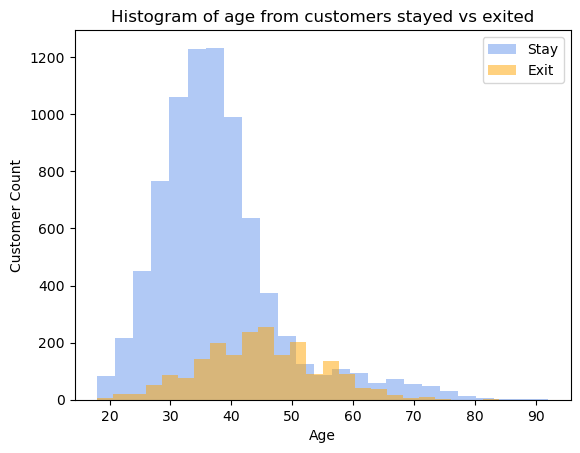

In [962]:
age_hist_stay = plt.hist(churn_data[churn_data.Exited == 0].Age, bins=25, alpha=0.5, color='cornflowerblue', label='Stay')
age_hist_exit = plt.hist(churn_data[churn_data.Exited == 1].Age, bins=25, alpha=0.5, color='orange', label='Exit')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Customer Count')
plt.title('Histogram of age from customers stayed vs exited')

In [963]:
def plot_by_exit_mean(grouped_churn, column, fmt='', ylabel=''):
    # plot data as bars
    width = 0.2
    x = grouped_churn.index
    bars = plt.bar(x, grouped_churn[column], width=width, color='cornflowerblue')
    plt.xticks(x, labels=['Stayed', 'Exited'])
    plt.bar_label(bars, label_type='edge', fmt=fmt)
    plt.ylabel(ylabel)
    plt.title(f'Mean {column} of customers that stayed vs exited')

## Balance of customers that stayed vs that left
##### Conclusion:
Customers with high balance (on average) are leaving, these might be high value customer. There needs to be some action to hold these customers.

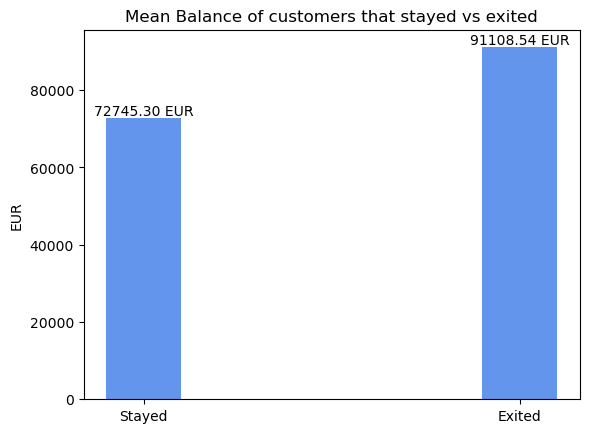

In [964]:
plot_by_exit_mean(grouped_churn, 'Balance', fmt='%.2f EUR', ylabel='EUR')

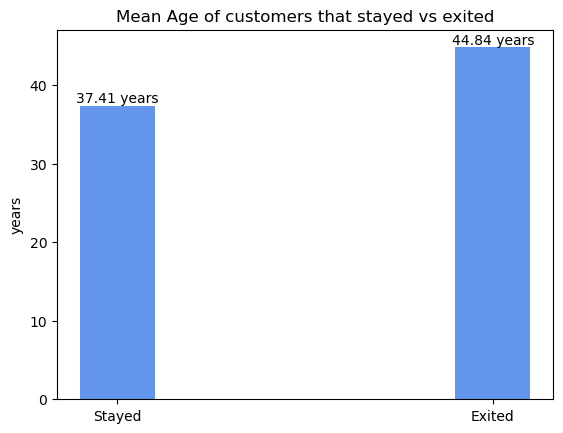

In [965]:
plot_by_exit_mean(grouped_churn, 'Age', '%.2f years', ylabel='years')

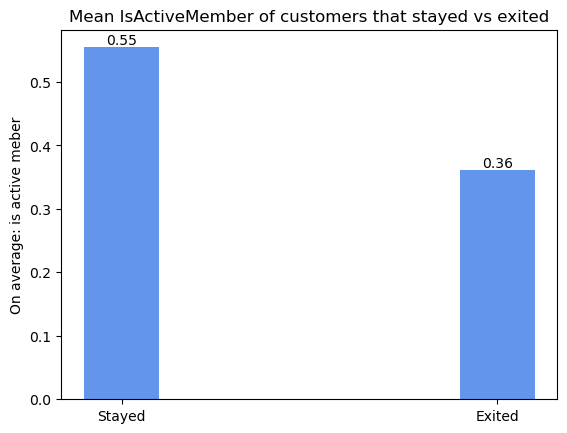

In [966]:
plot_by_exit_mean(grouped_churn, 'IsActiveMember', '%.2f', ylabel='On average: is active meber')

### Class Balance
* about 20% of the customers in our dataset exited the bank

In [967]:
churn_data.groupby('Exited')['CustomerId'].count()

Exited
0    7963
1    2037
Name: CustomerId, dtype: int64

# Clean data
Data is already quite clean, but I still do some checks here

In [968]:
# how many rows with nan do we have?
churn_data.shape[0] - churn_data.dropna().shape[0]
# result: 0 -> we don't have any nans

0

In [969]:
# drop surname, as we don't need it
churn_data = churn_data.drop('Surname', axis=1)
churn_data

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,
1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [970]:
# look at correlation of the different variables and if we need to drop some (that are highly correlated)
corr = churn_data.corr()
corr.where(np.abs(corr) > 0.1, '-')  # pretty printing for faster detection

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1.0,-,-,-,-,-,-,-,-,-
CreditScore,-,1.0,-,-,-,-,-,-,-,-
Age,-,-,1.0,-,-,-,-,-,-,0.285323
Tenure,-,-,-,1.0,-,-,-,-,-,-
Balance,-,-,-,-,1.0,-0.30418,-,-,-,0.118533
NumOfProducts,-,-,-,-,-0.30418,1.0,-,-,-,-
HasCrCard,-,-,-,-,-,-,1.0,-,-,-
IsActiveMember,-,-,-,-,-,-,-,1.0,-,-0.156128
EstimatedSalary,-,-,-,-,-,-,-,-,1.0,-
Exited,-,-,0.285323,-,0.118533,-,-,-0.156128,-,1.0


### Categorical and numerical data

In [971]:
ids = ['CustomerId']  # to be removed before training
label_col = ['Exited']
categorical_cols = ['Geography', 'Gender']
binary_cols = ['HasCrCard', 'IsActiveMember']
numeric = churn_data.columns.drop(ids + categorical_cols + binary_cols)  # all other columns

In [972]:
# transoform categorical columns into one hot encoding
for col in categorical_cols:
    categories_encoded = pd.get_dummies(churn_data[col], prefix=col)
    churn_data.drop(col, inplace=True, axis=1)
    churn_data = churn_data.join(categories_encoded)

In [973]:
churn_data[:10]

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
RowNumber,,,,,,,,,,,,,,,
1,15634602,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
2,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
3,15619304,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
4,15701354,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
5,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
6,15574012,645,44,8,113755.78,2,1,0,149756.71,1,0,0,1,0,1
7,15592531,822,50,7,0.00,2,1,1,10062.80,0,1,0,0,0,1
8,15656148,376,29,4,115046.74,4,1,0,119346.88,1,0,1,0,1,0
9,15792365,501,44,4,142051.07,2,0,1,74940.50,0,1,0,0,0,1


# Start with the model

In [974]:
# drop customer ID from here on
churn_data.drop(ids, inplace=True, axis=1)

## Make data split

In [975]:
y = churn_data[label_col]
X = churn_data[churn_data.columns.drop(label_col)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17, shuffle=True)

### Train SVM

##### Conclusion:
* False-Positive quite high compared to True Negative

In [976]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
svm.fit(X_train, y_train)

# see if class balance is improving the classification
svm_balanced = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf', class_weight='balanced'))
svm_balanced.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma='auto'))])

Accuracy: 0.8542424242424242
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      2625
           1       0.80      0.38      0.52       675

    accuracy                           0.85      3300
   macro avg       0.83      0.68      0.72      3300
weighted avg       0.85      0.85      0.83      3300



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


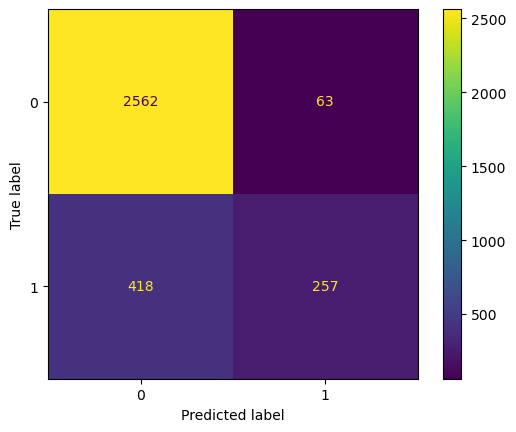

In [977]:
y_pred_test = svm.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(svm, X_test, y_test)

Accuracy: 0.7987878787878788
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2625
           1       0.51      0.73      0.60       675

    accuracy                           0.80      3300
   macro avg       0.71      0.77      0.73      3300
weighted avg       0.84      0.80      0.81      3300



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


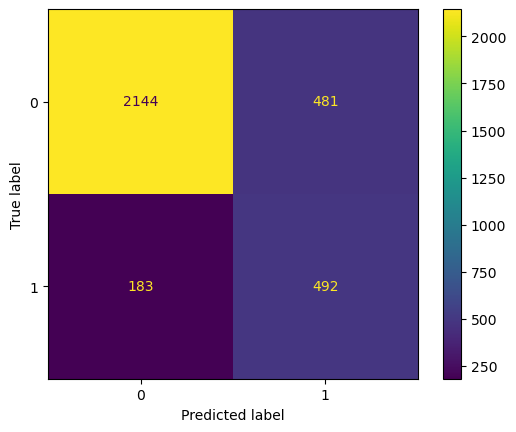

In [978]:
y_pred_test = svm_balanced.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(svm_balanced, X_test, y_test)

### Train Decision Tree

In [979]:
from sklearn import tree

dec_tree = tree.DecisionTreeClassifier()
dec_tree = dec_tree.fit(X_train, y_train)

Accuracy: 0.8003030303030303
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2625
           1       0.51      0.52      0.52       675

    accuracy                           0.80      3300
   macro avg       0.69      0.70      0.69      3300
weighted avg       0.80      0.80      0.80      3300



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


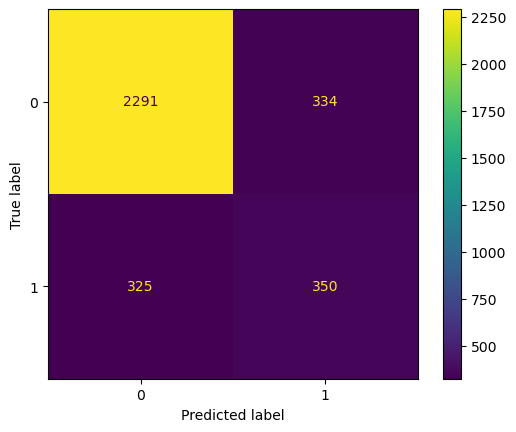

In [980]:
y_pred_test = dec_tree.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(dec_tree, X_test, y_test)

## Gradient Boosting

In [981]:
gboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=17)
gboost.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=1, max_depth=1, random_state=17)

Accuracy: 0.8618181818181818
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2625
           1       0.76      0.47      0.58       675

    accuracy                           0.86      3300
   macro avg       0.82      0.72      0.75      3300
weighted avg       0.85      0.86      0.85      3300



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


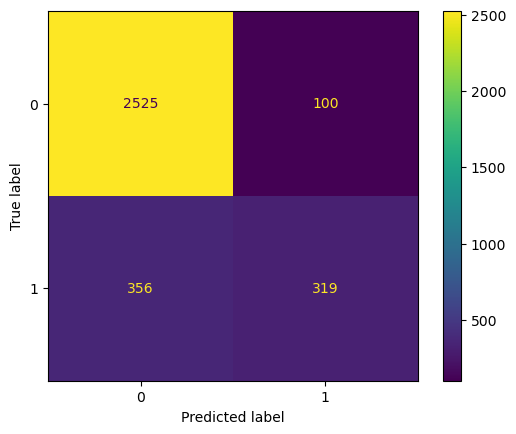

In [982]:
y_pred_test = gboost.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(gboost, X_test, y_test)

# Choose gboost with best accuracy
Depending on what is important for the prediction, other metrics might be important. For this example, we could also choose a model where the False-Negative is higher, if we want to weight this higher (It would be worse for us, if a customer is leaving and we didn't detect the customer). But for this purpose, we just look for the accuracy.

### Rank customer: Who should we approach first
In the next step, we will rank the customers based on their predicted score and the balance. Usually, I would look more into the actual profit of the individual customer to calculate the weighted profit that could be lost by churn. But since we don't have the profit and the balance might be correlated with the profit, I will use this to calculate the value of the customer.

In [983]:
model = gboost  # select the model
# get the churn probability: How likely will the customer leave the bank?
proba_exit = model.predict_proba(X_test)[:,1]
proba_exit.shape

(3300,)

In [984]:
X_test_result = X_test
X_test_result['score'] = proba_exit
X_test_result['weighted_balance'] = X_test_result['Balance'] * X_test_result['score']
X_test_result = X_test_result.sort_values(by=['weighted_balance'], ascending=False)
print('The rank: Which customer should we approach first? See variable: weighted_balance')
X_test_result[:30]

The rank: Which customer should we approach first? See variable weighted_balance


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,score,weighted_balance
RowNumber,,,,,,,,,,,,,,,
2093,655,38,3,250898.09,3,0,1,81054.00,0,0,1,0,1,1.000000,250898.090000
3281,583,57,3,238387.56,1,0,1,147964.99,1,0,0,1,0,1.000000,238387.560000
8734,749,42,9,222267.63,1,0,0,101108.85,0,0,1,0,1,1.000000,222267.630000
3589,489,40,3,221532.80,1,1,0,171867.08,0,0,1,0,1,1.000000,221532.800000
6718,663,58,5,216109.88,1,0,1,74176.71,0,0,1,1,0,1.000000,216109.880000
1068,650,26,4,214346.96,2,1,0,128815.33,0,1,0,0,1,1.000000,214346.960000
5872,479,33,2,208165.53,1,0,0,50774.81,1,0,0,1,0,0.990940,206279.584175
8983,504,32,8,206663.75,1,0,0,16281.94,1,0,0,1,0,0.910212,188107.865671
8684,697,49,7,195238.29,4,0,1,131083.56,1,0,0,1,0,0.931294,181824.286640


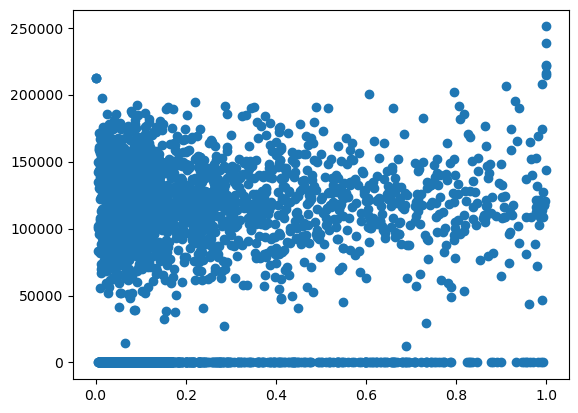

In [985]:
plt.scatter(X_test_result['score'], X_test_result['Balance'])

#### Cumulative sum of the weighted (account) balance
With the cumulative sum of the weighted (account) balance, we can that we need to approach a few high risk, high (account) balance customer. 

The weighted balance is caluclated for each costumer by: Balance * churn probability. The higher the weighted balance of a costumer, the more valuable for the bank and on risk to leave the bank he is. 

In the plot, we can see the cumulative sum of this metric, which means, the customers on the lower left should be approached at first, as we would loose their 'Balance' for the bank. We can also see, that a few customers actually hold big Balances.


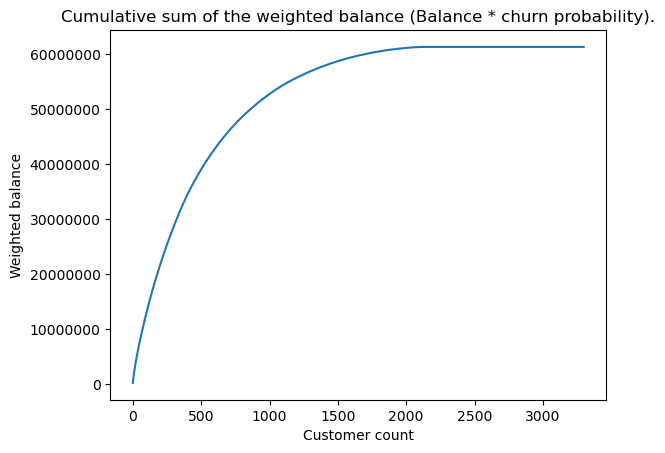

In [986]:
wb_cumsum = list(X_test_result.sort_values(by=['weighted_balance'], ascending=False)['weighted_balance'].cumsum())  # cumsum of the weighted balance
customer_count = 500
# print(f'{customer_count} customers make {wb_cumsum[customer_count] / wb_cumsum[-1]} of the weighted balance')
plt.plot(range(X_test_result.shape[0]), wb_cumsum)
plt.title('Cumulative sum of the weighted balance (Balance * churn probability).')
plt.xlabel('Customer count')
plt.ylabel('Weighted balance')
plt.ticklabel_format(style='plain')